# 📘 Notebook 2 — Exploratory Data Analysis & Risk Drivers

**Goal:**  
Explore the synthetic insurance portfolio data and identify major drivers of claim frequency and severity.

**Tasks:**
1. Environment setup  
2. Load and prepare dataset  
3. Correlation and covariance analysis  
4. Visualize key risk factors  
5. Feature–target relationships (frequency and severity)  
6. Save summarized outputs for modeling

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_RAW = BASE_DIR / "data" / "raw"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"

FIGURES.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD DATA
# ===============================================================

DATA_PATH = DATA_RAW / "synthetic_insurance_portfolio.csv"
df = pd.read_csv(DATA_PATH)

print(f"✅ Data loaded. Shape: {df.shape}")
display(df.head(3))

✅ Data loaded. Shape: (100000, 20)


,policy_id,exposure,driver_age,years_licensed,vehicle_age,vehicle_type,engine_power_kw,annual_mileage_km,region,urban_density,garage,bonus_malus,prior_claims_3y,commercial_use,telematics_opt_in,sum_insured,policy_year,num_claims,total_claim_amount,avg_claim_amount
0,P0000001,1.0,34,16,10,sedan,93,13495,NW,urban,False,1.022932,0,False,False,38102.869468,2025,0,0.0,0.0
1,P0000002,1.0,50,31,8,hatchback,100,18575,NW,urban,False,0.939265,0,True,False,24193.195534,2025,0,0.0,0.0
2,P0000003,1.0,45,29,7,sedan,144,37331,NW,urban,False,0.881326,0,False,False,45956.986290,2023,0,0.0,0.0


In [3]:
# %% ===============================================================
# STEP 2 — FEATURE OVERVIEW
# ===============================================================

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")

Numeric features: 13
Categorical features: 7


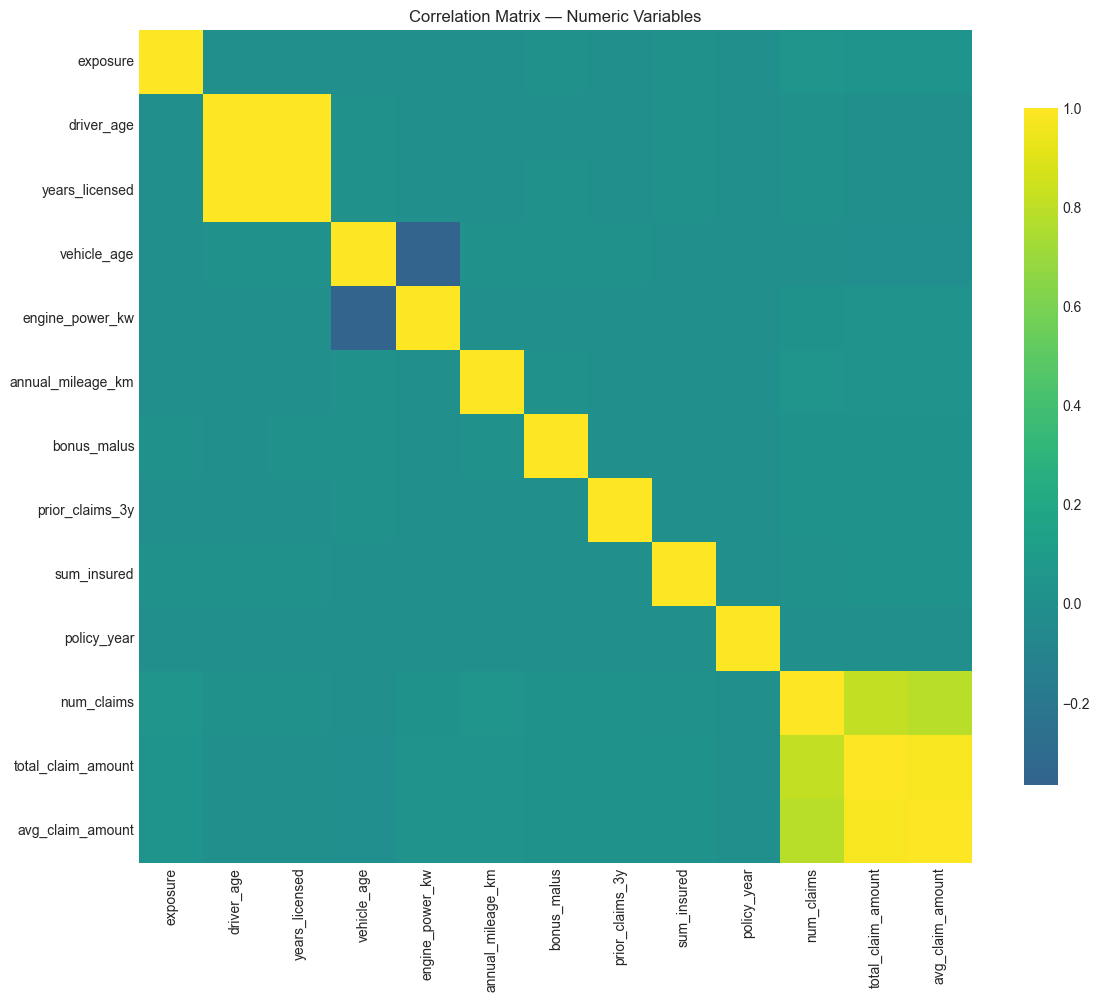

num_claims            1.000000
total_claim_amount    0.809259
avg_claim_amount      0.783756
exposure              0.042795
annual_mileage_km     0.040529
bonus_malus           0.018981
prior_claims_3y       0.015030
engine_power_kw       0.013612
sum_insured           0.004212
driver_age            0.004193
Name: num_claims, dtype: float64

In [4]:
# %% ===============================================================
# STEP 3 — CORRELATION MATRIX
# ===============================================================

corr = df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="viridis", center=0, square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix — Numeric Variables")
plt.tight_layout()
plt.savefig(FIGURES / "correlation_matrix.png")
plt.show()

corr["num_claims"].sort_values(ascending=False).head(10)

In [5]:
# %% ===============================================================
# STEP 4 — CLAIM FREQUENCY BY CATEGORY
# ===============================================================

def claim_rate_by(cat_col):
    tmp = (
        df.groupby(cat_col)
        .agg(n_policies=("policy_id", "count"),
             total_claims=("num_claims", "sum"))
        .assign(claim_rate=lambda x: x["total_claims"] / x["n_policies"])
        .sort_values("claim_rate", ascending=False)
    )
    return tmp

for col in ["vehicle_type", "urban_density", "region", "garage", "commercial_use", "telematics_opt_in"]:
    print(f"\n📊 Claim Frequency by {col}")
    display(claim_rate_by(col))


📊 Claim Frequency by vehicle_type


,n_policies,total_claims,claim_rate
vehicle_type,,,
sports,7911,822,0.103906
van,10084,837,0.083003
SUV,22003,1811,0.082307
sedan,31987,2625,0.082065
hatchback,28015,2246,0.080171



📊 Claim Frequency by urban_density


,n_policies,total_claims,claim_rate
urban_density,,,
rural,20290,1724,0.084968
urban,39552,3298,0.083384
suburban,40158,3319,0.082649



📊 Claim Frequency by region


,n_policies,total_claims,claim_rate
region,,,
HE,8187,752,0.091853
TH,2748,245,0.089156
ST,2718,242,0.089036
BE,2566,227,0.088465
BW,14219,1237,0.086996
RP,5198,449,0.086379
MV,1523,130,0.085358
SH,3517,300,0.085300
SN,5351,449,0.083910



📊 Claim Frequency by garage


,n_policies,total_claims,claim_rate
garage,,,
True,55039,4602,0.083613
False,44961,3739,0.083161



📊 Claim Frequency by commercial_use


,n_policies,total_claims,claim_rate
commercial_use,,,
True,7954,692,0.0870
False,92046,7649,0.0831



📊 Claim Frequency by telematics_opt_in


,n_policies,total_claims,claim_rate
telematics_opt_in,,,
False,79931,6811,0.085211
True,20069,1530,0.076237


In [6]:
# %% ===============================================================
# STEP 5 — SEVERITY BY FEATURE
# ===============================================================

def severity_by(cat_col):
    tmp = (
        df.loc[df["num_claims"] > 0]
        .groupby(cat_col)
        .agg(mean_severity=("avg_claim_amount", "mean"),
             claim_count=("num_claims", "sum"))
        .sort_values("mean_severity", ascending=False)
    )
    return tmp

for col in ["vehicle_type", "urban_density", "garage", "commercial_use", "telematics_opt_in"]:
    print(f"\n💰 Mean Severity by {col}")
    display(severity_by(col))


💰 Mean Severity by vehicle_type


,mean_severity,claim_count
vehicle_type,,
sports,3719.935731,822
SUV,3044.172791,1811
sedan,2761.899494,2625
hatchback,2746.122926,2246
van,2689.910324,837



💰 Mean Severity by urban_density


,mean_severity,claim_count
urban_density,,
suburban,2922.359234,3319
rural,2895.891259,1724
urban,2891.289518,3298



💰 Mean Severity by garage


,mean_severity,claim_count
garage,,
False,2934.726998,3739
True,2880.075018,4602



💰 Mean Severity by commercial_use


,mean_severity,claim_count
commercial_use,,
True,3173.146515,692
False,2880.386493,7649



💰 Mean Severity by telematics_opt_in


,mean_severity,claim_count
telematics_opt_in,,
False,2910.615467,6811
True,2877.766392,1530


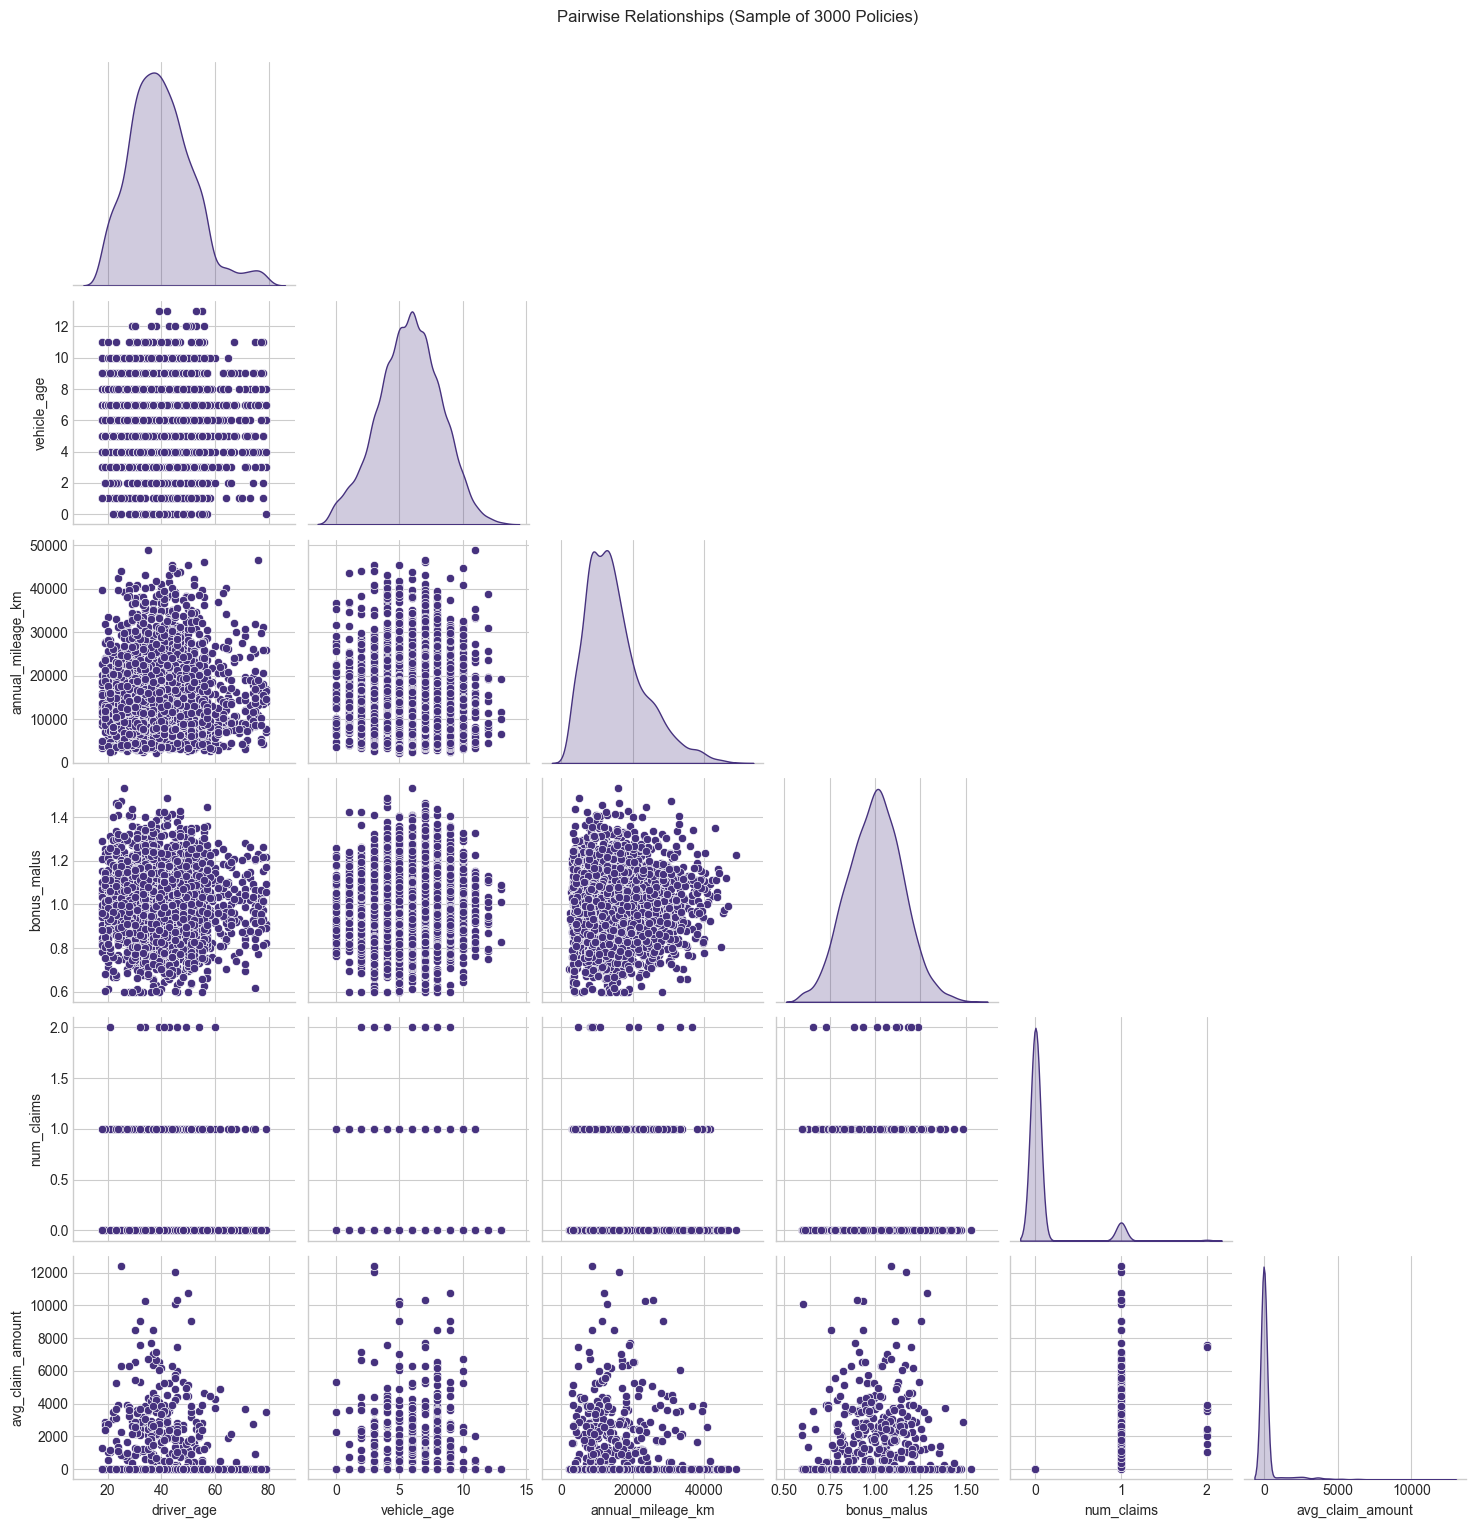

In [7]:
# %% ===============================================================
# STEP 6 — PAIRWISE VISUAL EXPLORATION
# ===============================================================

pair_vars = ["driver_age", "vehicle_age", "annual_mileage_km", "bonus_malus", "num_claims", "avg_claim_amount"]

sns.pairplot(df[pair_vars].sample(3000, random_state=42), diag_kind="kde", corner=True)
plt.suptitle("Pairwise Relationships (Sample of 3000 Policies)", y=1.02)
plt.savefig(FIGURES / "pairwise_relationships.png", bbox_inches="tight")
plt.show()

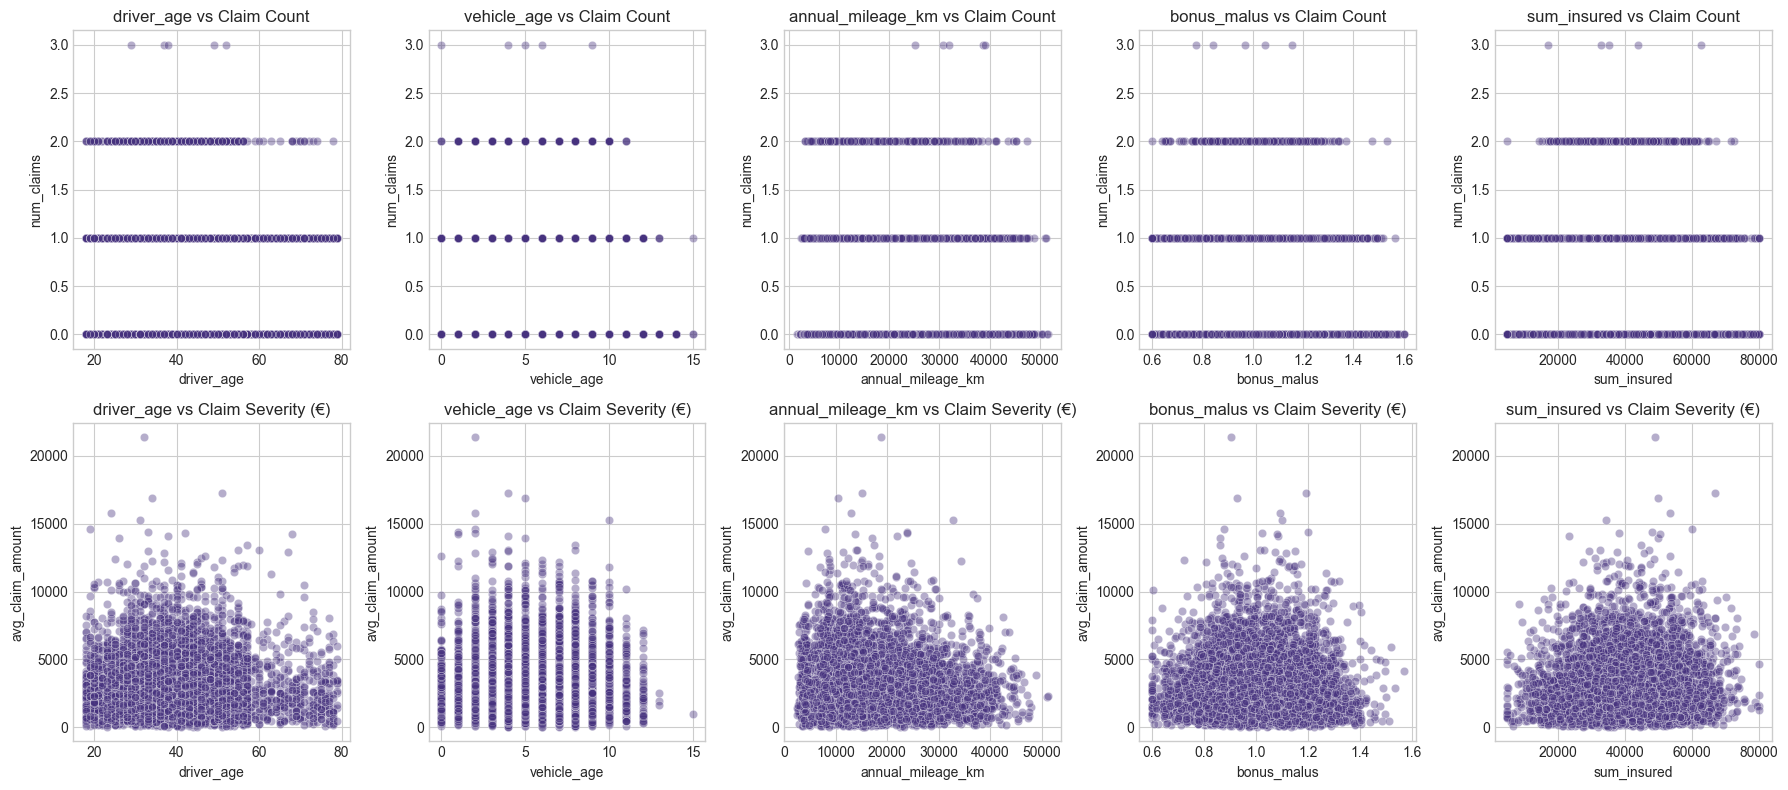

In [8]:
# %% ===============================================================
# STEP 7 — FREQUENCY & SEVERITY VS NUMERIC DRIVERS
# ===============================================================

num_features = ["driver_age", "vehicle_age", "annual_mileage_km", "bonus_malus", "sum_insured"]

fig, axes = plt.subplots(2, len(num_features), figsize=(18, 8))
axes = axes.ravel()

for i, col in enumerate(num_features):
    sns.scatterplot(x=col, y="num_claims", data=df, ax=axes[i], alpha=0.4)
    axes[i].set_title(f"{col} vs Claim Count")

for i, col in enumerate(num_features):
    sns.scatterplot(x=col, y="avg_claim_amount", data=df[df["avg_claim_amount"] > 0], ax=axes[i+len(num_features)], alpha=0.4)
    axes[i+len(num_features)].set_title(f"{col} vs Claim Severity (€)")

plt.tight_layout()
plt.show()

In [9]:
# %% ===============================================================
# STEP 8 — SAVE SUMMARY TABLES
# ===============================================================

freq_summary = df.groupby("vehicle_type")["num_claims"].mean().rename("freq").reset_index()
sev_summary = df.loc[df["num_claims"] > 0].groupby("vehicle_type")["avg_claim_amount"].mean().rename("severity").reset_index()

summary = freq_summary.merge(sev_summary, on="vehicle_type", how="outer")
summary["pure_premium"] = summary["freq"] * summary["severity"]

summary_path = OUTPUTS / "reports" / "eda_vehicle_summary.csv"
summary.to_csv(summary_path, index=False)

print(f"✅ Saved summary to {summary_path}")
display(summary)

✅ Saved summary to ../outputs/reports/eda_vehicle_summary.csv


,vehicle_type,freq,severity,pure_premium
0,SUV,0.082307,3044.172791,250.556602
1,hatchback,0.080171,2746.122926,220.160346
2,sedan,0.082065,2761.899494,226.654146
3,sports,0.103906,3719.935731,386.523470
4,van,0.083003,2689.910324,223.270026


## ✅ Summary

Key observations:

- **Claim frequency** varies strongly by vehicle type and usage (sports/commercial ↑).  
- **Severity** is driven mainly by vehicle type, power, and sum insured.  
- **Bonus–Malus** and **mileage** correlate positively with claim likelihood.  
- Data behaves as intended — synthetic realism preserved.

Next step:  
👉 Proceed to `03_model_frequency.ipynb` for Poisson regression modeling of claim counts.